## Regression Plot

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

#### Load all datasets and pool them

In [71]:
yellow_cab_PU = pd.read_csv('Yellow_Cab_data/data_regression_PU.csv')
green_cab_PU = pd.read_csv('Green_Cab_data/data_regression_PU.csv')
fhv_PU = pd.read_csv('For_Hire_Vehicle_data/data_regression_PU_with_HV.csv')
pooled_PU = pd.read_csv('Pooled_data/data_regression_PU.csv')
chicago_PU = pd.read_csv('Chigaco_data/chicago_PU_regression.csv')

In [3]:
yellow_cab_DO = pd.read_csv('Yellow_Cab_data/data_regression_DO.csv')
green_cab_DO = pd.read_csv('Green_Cab_data/data_regression_DO.csv')

### New York Regressions

In [5]:

from linearmodels.panel import PanelOLS


# rename bins so linearmodels can handle them

taxi_data_cut['temp_bins'] = pd.Categorical(taxi_data_cut['temp_bins'], ordered=False).astype(str)
# rename bins so linearmodels can handle them
taxi_data_cut['temp_bins'] = taxi_data_cut['temp_bins'].str.replace('\(', '[', regex=True)
# Create a panel data structure
panel_data = taxi_data_cut.set_index([ 'PULocationID', 'Year_fact'])


# model_formula = 'log_total ~  C(temp_bins, Treatment(reference = "[16.0, 19.0]")) + PRCP + AWND + Weekday_index + holiday + C(Month_fact) + EntityEffects + TimeEffects' + windspeeed_obs
model_formula = 'log_total ~  1+ C(temp_bins, Treatment(reference = "[16.0, 19.0]")) + pr_obs + Snowdepth  + windspeed_obs +Weekday_index + dynamic_tourism + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + EntityEffects + TimeEffects'
model = PanelOLS.from_formula(model_formula, data=panel_data)

# Fit the model
results = model.fit(cov_type='clustered', cluster_entity=True)

# Print the regression results in latex format
print(results)

c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:              log_total   R-squared:                        0.1169
Estimator:                   PanelOLS   R-squared (Between):             -0.2276
No. Observations:              405215   R-squared (Within):               0.3288
Date:                Sat, Dec 09 2023   R-squared (Overall):              0.0310
Time:                        15:01:54   Log-likelihood                -1.032e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2143.8
Entities:                         257   P-value                           0.0000
Avg Obs:                       1576.7   Distribution:               F(25,404928)
Min Obs:                       1.0000                                           
Max Obs:                       1846.0   F-statistic (robust):             211.91
                            

### Chicago Regressions

In [294]:
chicago_PU = pd.read_csv('Chigaco_data/chicago_PU_regression.csv')

In [295]:
from linearmodels.panel import PanelOLS


chicago_PU['temp_bins'] = pd.Categorical(chicago_PU['temp_bins'], ordered=False).astype(str)
chicago_PU['temp_bins'] = chicago_PU['temp_bins'].str.replace('\(', '[', regex=True)

# add cheby polynomials for chicago

num_days = len(chicago_PU["date_pickup"].unique())

chicago_PU["cheby_0"] = 1
chicago_PU['cheby_1'] = chicago_PU['date_pickup'].rank(method='dense').astype(int) / num_days

for i in range(2, 6):
    chicago_PU[f"cheby_{i}"] = (2 * chicago_PU["cheby_1"] * chicago_PU[f"cheby_{i-1}"]) - chicago_PU[f"cheby_{i-2}"]


panel_data = chicago_PU.set_index(['PULocationID', 'Year_fact'])


model_formula = 'log_total ~ 1 +  C(temp_bins, Treatment(reference = "[16.0, 19.0]")) + PRCP + AWND + Weekday_index + holiday + + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + EntityEffects + TimeEffects'

model = PanelOLS.from_formula(model_formula, data=panel_data)

# Fit the model
results_chicago = model.fit(cov_type='clustered', cluster_entity=True)

# Print the regression results in latex format
print(results_chicago)

c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:              log_total   R-squared:                        0.0074
Estimator:                   PanelOLS   R-squared (Between):             -4.3267
No. Observations:             1545599   R-squared (Within):               0.0455
Date:                Tue, Nov 07 2023   R-squared (Overall):             -0.0113
Time:                        14:58:54   Log-likelihood                -2.131e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      459.07
Entities:                          77   P-value                           0.0000
Avg Obs:                    2.007e+04   Distribution:              F(25,1545493)
Min Obs:                       1.0000                                           
Max Obs:                    1.714e+05   F-statistic (robust):             1403.9
                            

In [260]:
def plot_regression(model_fit,dataset,fixed_effect_level,outcome):
    """
    Plots coefficients for log_trip number and their condifence intervals against each temperature bin.

    Inputs:
        model_fit: the fitted regression model
        dataset(str): Green,Yellow or FHV
        fixed_effect_level(str): Pickup or Dropoff Location
        outcome(str): Trip number or Trip distance
    
    
    Returns:
       Plot
    
    """
    results = model_fit

    # Prepare summary for plotting

    coefficients = results.params
    conf_int = results.conf_int()

    # Combine coefficients and confidence intervals into a single DataFrame
    df = pd.DataFrame(pd.concat([coefficients, conf_int], axis=1))
    df.columns = ['Coefficient', 'Lower CI', 'Upper CI']

    # convert the index into a regular column
    df.reset_index(inplace=True)

    # only keep the rows where index starts with C(temp_bins)
    df = df[df['index'].str.startswith('C(temp_bins')]

    # add temperature variable to the dataframe which drops everything from the string until the first "T."

    df['Temperature'] = df['index'].str.split(r'\[T\.').str[1].str[:-1]

    df.drop(columns=['index'], inplace=True)

    # Convert Temperature intervals into numerical values
    df['Temperature'] = df['Temperature'].str.strip('[]').str.split(',').apply(lambda x: (float(x[0]) + float(x[1])) / 2)
    # order the dataframe by temperature
    df = df.sort_values(by=['Temperature'])

    # convert the coeffients into percentages and adapt CI accordingly
    df['Coefficient'] = df['Coefficient'] * 100
    df['Lower CI'] = df['Lower CI'] * 100
    df['Upper CI'] = df['Upper CI'] * 100

    # Extract Temperature and Coefficient values
    temperature = df['Temperature']
    coefficient = df['Coefficient']

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(temperature, coefficient, color='blue', label='Data')
    plt.xlabel('Temperature')
    plt.ylabel(f'{outcome} response in %')
    plt.title(f'Mobility response by temperature bin- {dataset}')

    # Add confidence intervals if needed
    lower_ci = df['Lower CI']
    upper_ci = df['Upper CI']
    plt.errorbar(temperature, coefficient, yerr=[coefficient - lower_ci, upper_ci - coefficient], fmt='o', color='red' , capsize= 3,  barsabove = True , label='Confidence Interval')

    # Fit a polynomial
    degree = 2
    coefficients_poly = np.polyfit(temperature, coefficient, degree)
    y_poly = np.polyval(coefficients_poly, temperature)

    # Plot the polynomial curve
    plt.plot(temperature, y_poly, label=f'Polynomial Fit (Degree {degree})', color='green')

    # add a dotted line at 0 percent
    plt.axhline(y=0, color='blue', linestyle='--')

    # Add a legend
    plt.legend()
    plt.text(0.5, -0.15, f'Red dots show the coefficients for the temperature bins (each 3°C ) on log({outcome}) as the dependent variable in a panel regression which \n included month and {fixed_effect_level} fixed effects. Standard Errors are clustered at the borough level. Percentage change in trips is relative to the 16-19°C bin. \n Trips which started or ended at the airport are excluded from the analysis. The specification includes Chebyshev polynomials up until order 5' , ha='center', va='center', transform=plt.gca().transAxes)
    # Show the plot
    plt.show()


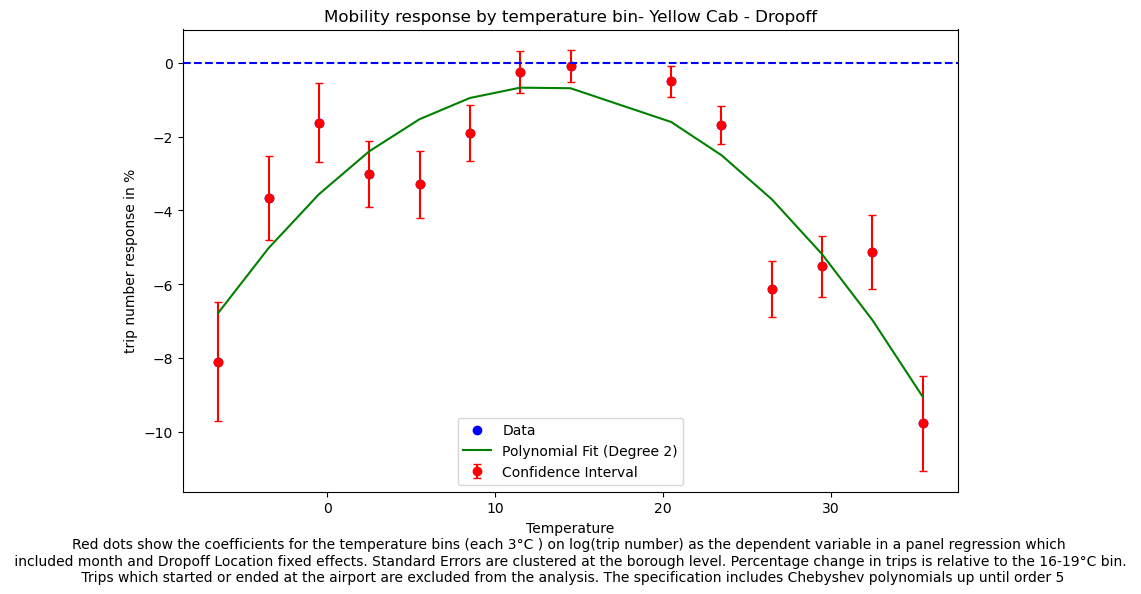

In [300]:
plot_regression(results,'Yellow Cab - Dropoff','Dropoff Location','trip number')